<a href="https://colab.research.google.com/github/shreyansh273/Football-Scouting/blob/main/Player_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files = files.upload()

Saving players_value.csv to players_value.csv


In [2]:
from google.colab import files
files = files.upload()

Saving all_players_stats.csv to all_players_stats.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
player_stats = pd.read_csv("all_players_stats.csv")
player_stats.drop("Unnamed: 0", axis=1, inplace=True)
player_stats.head(1)

,player,nationality,position,squad,age,birth_year,games,games_starts,minutes,minutes_90s,goals,assists,non_penalty_goals,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,npxg_xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,shots_total,shots_on_target,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,distance_from_goal,shots_free_kicks,...,touches_def_pen_area,touches_def_3rd,touches_mid_3rd,touches_att_3rd,touches_att_pen_area,touches_live_ball,dribbles_completed,dribbles,dribbles_completed_pct,players_dribbled_past,nutmegs,carries,carry_distance,carry_progressive_distance,progressive_carries,carries_into_final_third,carries_into_penalty_area,miscontrols,dispossessed,pass_targets,passes_received,passes_received_pct,progressive_passes_received,sca,sca_per90,sca_passes_live,sca_passes_dead,sca_dribbles,sca_shots,sca_fouled,sca_og_for,gca,gca_per90,gca_passes_live,gca_passes_dead,gca_dribbles,gca_shots,gca_fouled,gca_og_for,League
0,Patrick van Aanholt,nl NED,DF,Crystal Palace,29.0,1990.0,22,20,1777,19.7,0,1,0,0,0,2,0,0.0,0.05,0.05,0.0,0.05,1.2,1.2,0.8,2.0,0.06,0.04,0.1,0.06,0.1,18,6,33.3,0.91,0.3,0.0,0.0,20.3,3.0,...,72.0,405.0,643.0,344.0,38.0,1126.0,9.0,21.0,42.9,9.0,0.0,733.0,3522.0,1907.0,114.0,30.0,9.0,13.0,16.0,835.0,775.0,92.8,46.0,26.0,1.32,22.0,3.0,1.0,0.0,0.0,0.0,3.0,0.15,2.0,1.0,0.0,0.0,0.0,0.0,Premier-League


In [18]:
player_value = pd.read_csv("players_value.csv")
player_value.drop("Unnamed: 0", axis=1, inplace=True)
player_value.head(1)

,Name,Field Position,Age,Market Value (Millions)
0,Pedro Henrique,Left Winger,31,1.08


In [19]:
player_stats = player_stats.merge(player_value, how='left', left_on="player", right_on="Name").drop(["Name","Age"], axis=1)
player_stats.head(1)

,player,nationality,position,squad,age,birth_year,games,games_starts,minutes,minutes_90s,goals,assists,non_penalty_goals,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,npxg_xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,shots_total,shots_on_target,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,distance_from_goal,shots_free_kicks,...,touches_mid_3rd,touches_att_3rd,touches_att_pen_area,touches_live_ball,dribbles_completed,dribbles,dribbles_completed_pct,players_dribbled_past,nutmegs,carries,carry_distance,carry_progressive_distance,progressive_carries,carries_into_final_third,carries_into_penalty_area,miscontrols,dispossessed,pass_targets,passes_received,passes_received_pct,progressive_passes_received,sca,sca_per90,sca_passes_live,sca_passes_dead,sca_dribbles,sca_shots,sca_fouled,sca_og_for,gca,gca_per90,gca_passes_live,gca_passes_dead,gca_dribbles,gca_shots,gca_fouled,gca_og_for,League,Field Position,Market Value (Millions)
0,Patrick van Aanholt,nl NED,DF,Crystal Palace,29.0,1990.0,22,20,1777,19.7,0,1,0,0,0,2,0,0.0,0.05,0.05,0.0,0.05,1.2,1.2,0.8,2.0,0.06,0.04,0.1,0.06,0.1,18,6,33.3,0.91,0.3,0.0,0.0,20.3,3.0,...,643.0,344.0,38.0,1126.0,9.0,21.0,42.9,9.0,0.0,733.0,3522.0,1907.0,114.0,30.0,9.0,13.0,16.0,835.0,775.0,92.8,46.0,26.0,1.32,22.0,3.0,1.0,0.0,0.0,0.0,3.0,0.15,2.0,1.0,0.0,0.0,0.0,0.0,Premier-League,Left-Back,6.3


In [28]:
player_stats[player_stats["Field Position"]=="Centre-Forward"]
player_stats[player_stats.player.str.contains("Kane")]

,player,nationality,position,squad,age,birth_year,games,games_starts,minutes,minutes_90s,goals,assists,non_penalty_goals,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,npxg_xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,shots_total,shots_on_target,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,distance_from_goal,shots_free_kicks,...,touches_mid_3rd,touches_att_3rd,touches_att_pen_area,touches_live_ball,dribbles_completed,dribbles,dribbles_completed_pct,players_dribbled_past,nutmegs,carries,carry_distance,carry_progressive_distance,progressive_carries,carries_into_final_third,carries_into_penalty_area,miscontrols,dispossessed,pass_targets,passes_received,passes_received_pct,progressive_passes_received,sca,sca_per90,sca_passes_live,sca_passes_dead,sca_dribbles,sca_shots,sca_fouled,sca_og_for,gca,gca_per90,gca_passes_live,gca_passes_dead,gca_dribbles,gca_shots,gca_fouled,gca_og_for,League,Field Position,Market Value (Millions)
246,Harry Kane,eng ENG,FW,Tottenham,27.0,1993.0,35,35,3082,34.2,23,14,19,4,4,1,0,0.67,0.41,1.08,0.55,0.96,20.5,17.5,7.4,24.8,0.6,0.22,0.81,0.51,0.73,134,47,35.1,3.91,1.37,0.14,0.4,17.7,14.0,...,736.0,616.0,166.0,1341.0,46.0,79.0,58.2,47.0,8.0,897.0,4616.0,2537.0,150.0,53.0,26.0,61.0,71.0,1761.0,1055.0,59.9,223.0,113.0,3.3,70.0,2.0,18.0,9.0,12.0,2.0,25.0,0.73,15.0,1.0,6.0,0.0,3.0,0.0,Premier-League,Centre-Forward,108.0


In [29]:
player_stats.describe()

,age,birth_year,games,games_starts,minutes,minutes_90s,goals,assists,non_penalty_goals,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,npxg_xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,shots_total,shots_on_target,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,distance_from_goal,shots_free_kicks,npxg_per_shot,xg_net,npxg_net,passes_completed,...,touches_def_pen_area,touches_def_3rd,touches_mid_3rd,touches_att_3rd,touches_att_pen_area,touches_live_ball,dribbles_completed,dribbles,dribbles_completed_pct,players_dribbled_past,nutmegs,carries,carry_distance,carry_progressive_distance,progressive_carries,carries_into_final_third,carries_into_penalty_area,miscontrols,dispossessed,pass_targets,passes_received,passes_received_pct,progressive_passes_received,sca,sca_per90,sca_passes_live,sca_passes_dead,sca_dribbles,sca_shots,sca_fouled,sca_og_for,gca,gca_per90,gca_passes_live,gca_passes_dead,gca_dribbles,gca_shots,gca_fouled,gca_og_for,Market Value (Millions)
count,2895.000000,2895.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2896.000000,2896.000000,2346.000000,2896.000000,2896.000000,2346.000000,1969.000000,2343.000000,2893.000000,2343.000000,2893.000000,2893.000000,2893.000000,...,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2431.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2878.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2243.000000
mean,25.317098,1994.343351,19.262776,14.242403,1278.733080,14.208115,1.754834,1.220304,1.555939,0.198895,0.247238,2.520373,0.115677,0.103229,0.081443,0.184693,0.093035,0.174489,1.752506,1.563014,1.165572,2.729554,0.121773,0.078918,0.200722,0.111922,0.190805,15.087362,5.085635,29.992754,1.120204,0.346257,0.083167,0.275455,17.202732,0.599378,0.092134,0.003802,-0.005807,524.056689,...,86.248531,266.612859,386.477705,195.626685,28.724507,738.807466,12.492568,20.917041,61.764418,13.474248,0.839267,503.999309,2621.820947,1420.580366,54.558590,16.364328,4.829589,15.630487,14.562738,619.965088,523.814725,83.304448,43.165226,24.167992,1.800059,17.337366,2.126858,1.459385,1.223989,1.438299,0.582095,2.920152,0.196647,1.977186,0.185966,0.199793,0.238852,0.244037,0.074317,9.758744
std,4.649531,4.655466,11.685709,11.483710,988.699301,10.985646,3.405570,2.025012,2.902857,0.881872,1.026249,2.617781,0.344835,0.181622,0.229860,0.311215,0.163192,0.298543,3.030249,2.550227,1.662416,3.829837,0.201552,0.146385,0.266257,0.188663,0.254251,19.642266,7.713496,20.572875,1.578046,0.488765,0.110271,0.263859,5.827499,2.002650,0.058523,1.118327,1.096789,498.503830,...,192.352131,326.246809,378.554806,221.941336,39.388468,640.982192,16.231331,26.998912,22.004679,17.435014,1.661776,450.537137,2463.451989,1398.509848,58.733943,19.435142,8.747238,19.311614,17.238120,530.565116,472.403370,16.226273,60.320327,28.299734,2.792700,19.490526,5.602387,2.785092,1.989326,2.494686,1.004443,4.156373,0.375658,2.876101,0.661098,0.615195,0.588018,0.617212,0.285072,13.881569
min,14.000000,1977.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.400000,0.000000,0.010000,-6.000000,-5.

In [30]:
player_stats2 = player_stats.copy()
cols = player_stats2.columns[26:len(player_stats2.columns)-4]
for i in range(len(cols)):
  if ('per90' in cols[i]) or ('pct' in cols[i]):
    continue
  else:
    player_stats2[cols[i]+"_per90"] = player_stats2[cols[i]]/player_stats2["minutes_90s"]
    player_stats2.drop(cols[i], axis=1, inplace=True)
player_stats2.head(2)

,player,nationality,position,squad,age,birth_year,games,games_starts,minutes,minutes_90s,goals,assists,non_penalty_goals,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,npxg_xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,shots_on_target_pct,shots_total_per90,shots_on_target_per90,passes_pct,passes_pct_short,passes_pct_medium,passes_pct_long,dribble_tackles_pct,pressure_regain_pct,...,blocks_per90,blocked_shots_per90,blocked_shots_saves_per90,blocked_passes_per90,interceptions_per90,clearances_per90,errors_per90,touches_per90,touches_def_pen_area_per90,touches_def_3rd_per90,touches_mid_3rd_per90,touches_att_3rd_per90,touches_att_pen_area_per90,touches_live_ball_per90,dribbles_completed_per90,dribbles_per90,players_dribbled_past_per90,nutmegs_per90,carries_per90,carry_distance_per90,carry_progressive_distance_per90,progressive_carries_per90,carries_into_final_third_per90,carries_into_penalty_area_per90,miscontrols_per90,dispossessed_per90,pass_targets_per90,passes_received_per90,progressive_passes_received_per90,sca_passes_live_per90,sca_passes_dead_per90,sca_dribbles_per90,sca_shots_per90,sca_fouled_per90,sca_og_for_per90,gca_passes_live_per90,gca_passes_dead_per90,gca_dribbles_per90,gca_shots_per90,gca_fouled_per90
0,Patrick van Aanholt,nl NED,DF,Crystal Palace,29.0,1990.0,22,20,1777,19.7,0,1,0,0,0,2,0,0.00,0.05,0.05,0.00,0.05,1.2,1.2,0.8,2.0,0.06,0.04,0.10,0.06,0.10,33.3,0.913706,0.304569,78.9,88.7,81.3,52.0,35.7,33.5,...,1.573604,0.355330,0.050761,1.218274,1.725888,2.030457,0.050761,67.157360,3.654822,20.558376,32.639594,17.461929,1.928934,57.157360,0.456853,1.065990,0.456853,0.000000,37.208122,178.781726,96.802030,5.786802,1.522843,0.456853,0.659898,0.812183,42.385787,39.340102,2.335025,1.116751,0.152284,0.050761,0.000000,0.000000,0.0,0.101523,0.050761,0.0,0.0,0.000000
1,Tammy Abraham,eng ENG,FW,Chelsea,22.0,1997.0,22,12,1040,11.6,6,1,6,0,0,0,0,0.52,0.09,0.61,0.52,0.61,6.4,6.4,0.9,7.3,0.56,0.07,0.63,0.56,0.63,40.6,2.758621,1.120690,68.3,78.0,60.9,60.0,16.7,23.5,...,0.775862,0.172414,0.000000,0.603448,0.172414,1.465517,0.000000,30.689655,1.810345,3.448276,14.396552,14.310345,5.689655,29.913793,0.517241,1.637931,0.517241,0.172414,15.258621,61.120690,21.724138,1.120690,0.431034,0.344828,2.241379,1.120690,42.327586,21.637931,8.275862,0.948276,0.000000,0.086207,0.258621,0.258621,0.0,0.086207,0.000000,0.0,0.0,0.086207


In [32]:
player_stats2 = player_stats2.loc[player_stats2.games_starts>10]
player_stats2.head(2)

,player,nationality,position,squad,age,birth_year,games,games_starts,minutes,minutes_90s,goals,assists,non_penalty_goals,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,npxg_xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,shots_on_target_pct,shots_total_per90,shots_on_target_per90,passes_pct,passes_pct_short,passes_pct_medium,passes_pct_long,dribble_tackles_pct,pressure_regain_pct,...,blocks_per90,blocked_shots_per90,blocked_shots_saves_per90,blocked_passes_per90,interceptions_per90,clearances_per90,errors_per90,touches_per90,touches_def_pen_area_per90,touches_def_3rd_per90,touches_mid_3rd_per90,touches_att_3rd_per90,touches_att_pen_area_per90,touches_live_ball_per90,dribbles_completed_per90,dribbles_per90,players_dribbled_past_per90,nutmegs_per90,carries_per90,carry_distance_per90,carry_progressive_distance_per90,progressive_carries_per90,carries_into_final_third_per90,carries_into_penalty_area_per90,miscontrols_per90,dispossessed_per90,pass_targets_per90,passes_received_per90,progressive_passes_received_per90,sca_passes_live_per90,sca_passes_dead_per90,sca_dribbles_per90,sca_shots_per90,sca_fouled_per90,sca_og_for_per90,gca_passes_live_per90,gca_passes_dead_per90,gca_dribbles_per90,gca_shots_per90,gca_fouled_per90
0,Patrick van Aanholt,nl NED,DF,Crystal Palace,29.0,1990.0,22,20,1777,19.7,0,1,0,0,0,2,0,0.00,0.05,0.05,0.00,0.05,1.2,1.2,0.8,2.0,0.06,0.04,0.10,0.06,0.10,33.3,0.913706,0.304569,78.9,88.7,81.3,52.0,35.7,33.5,...,1.573604,0.355330,0.050761,1.218274,1.725888,2.030457,0.050761,67.157360,3.654822,20.558376,32.639594,17.461929,1.928934,57.157360,0.456853,1.065990,0.456853,0.000000,37.208122,178.781726,96.802030,5.786802,1.522843,0.456853,0.659898,0.812183,42.385787,39.340102,2.335025,1.116751,0.152284,0.050761,0.000000,0.000000,0.0,0.101523,0.050761,0.0,0.0,0.000000
1,Tammy Abraham,eng ENG,FW,Chelsea,22.0,1997.0,22,12,1040,11.6,6,1,6,0,0,0,0,0.52,0.09,0.61,0.52,0.61,6.4,6.4,0.9,7.3,0.56,0.07,0.63,0.56,0.63,40.6,2.758621,1.120690,68.3,78.0,60.9,60.0,16.7,23.5,...,0.775862,0.172414,0.000000,0.603448,0.172414,1.465517,0.000000,30.689655,1.810345,3.448276,14.396552,14.310345,5.689655,29.913793,0.517241,1.637931,0.517241,0.172414,15.258621,61.120690,21.724138,1.120690,0.431034,0.344828,2.241379,1.120690,42.327586,21.637931,8.275862,0.948276,0.000000,0.086207,0.258621,0.258621,0.0,0.086207,0.000000,0.0,0.0,0.086207


In [37]:
req_cols = ["player"]+player_stats2.columns[np.arange(26,len(player_stats2.columns))].tolist()
req_cols = [i for i in req_cols if i not in ["League","Field Position", "Market Value (Millions)"]]
forwards_cluster_data = player_stats2.loc[player_stats2["Field Position"] == "Centre-Forward", req_cols]
forwards_cluster_data.shape

(178, 96)

In [38]:
forwards_cluster_data = forwards_cluster_data[~forwards_cluster_data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [39]:
y = forwards_cluster_data["player"]
X = forwards_cluster_data.drop("player", axis=1)

In [40]:
from sklearn.preprocessing import MinMaxScaler

In [41]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [42]:
from sklearn.cluster import KMeans

In [43]:
errors = []
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, random_state=52)
  kmeans.fit(X_scaled)
  errors.append(kmeans.inertia_) 
  forwards_cluster_data["cluster_"+str(i)] = kmeans.labels_.tolist()

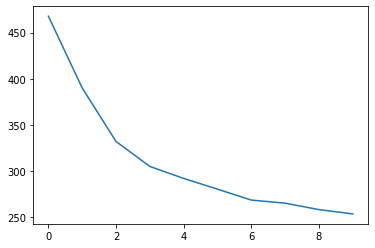

In [44]:
fig, ax = plt.subplots()
ax.plot(errors)

In [45]:
errors

[467.6750419031725,
 389.8290851719453,
 331.86912119219915,
 304.8372688154914,
 291.8429069683308,
 280.2113917011448,
 268.40428717126355,
 265.0510769367244,
 258.0412236812929,
 253.3808691397578]

In [52]:
forwards_cluster_data.groupby("cluster_10").size()

cluster_10
0    20
1     6
2    22
3     5
4    25
5    16
6     8
7    59
8     2
9    13
dtype: int64

In [47]:
errors = []
for i in range(1,100):
  kmeans = KMeans(n_clusters=8)
  kmeans.fit(X_scaled)
  errors.append(kmeans.inertia_)

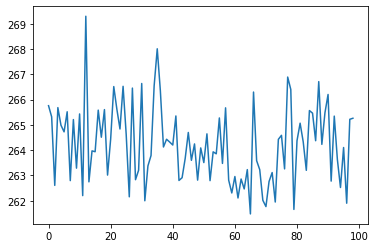

In [48]:
fig, ax = plt.subplots()
ax.plot(errors)

In [53]:
forwards_cluster_data.groupby(["cluster_10"])['xg_per90', 'xa_per90','shots_total_per90','shots_on_target_per90', 'passes_pct_short', 'passes_pct_medium', 'passes_pct_long','sca_per90','gca_per90','tackles_per90', 'blocks_per90', 'clearances_per90'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,xg_per90,xa_per90,shots_total_per90,shots_on_target_per90,passes_pct_short,passes_pct_medium,passes_pct_long,sca_per90,gca_per90,tackles_per90,blocks_per90,clearances_per90
cluster_10,,,,,,,,,,,,
0,0.588000,0.127000,2.906113,1.244125,80.355000,73.930000,68.590000,2.240352,0.388607,0.566483,0.535596,0.523953
1,0.741667,0.188333,4.028538,1.609917,83.150000,77.766667,64.150000,3.349734,0.636645,0.415749,0.587802,0.733805
2,0.380909,0.160000,2.451252,0.961618,79.881818,75.259091,59.022727,2.639991,0.420261,0.835133,0.863154,0.506887
3,0.042000,0.072000,0.531711,0.168060,93.240000,93.640000,79.380000,1.408594,0.209573,2.229717,1.667951,2.829051
4,0.300800,0.092400,2.204530,0.751077,73.028000,64.376000,54.868000,1.839874,0.210113,1.118854,1.174026,0.988194
5,0.261875,0.108125,1.996653,0.780370,81.056250,72.568750,58.881250,2.422919,0.259946,1.641106,1.233016,0.717799
6,0.398750,0.133750,2.539841,1.064902,81.062500,73.400000,68.362500,2.907069,0.563067,0.736351,1.000703,0.420933
7,0.362203,0.082034,2.165187,0.846711,78.410169,72.052542,63.925424,1.732794,0.242037,0.576862,0.728526,0.774928
8,0.970000,0.235000,4.449811,2.015152,84.550000,78.200000,48.350000,5.120265,1.092803,0.795455,0.727273,0.351326


In [57]:
forwards_cluster_data[forwards_cluster_data.cluster_10==1]

,player,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,shots_on_target_pct,shots_total_per90,shots_on_target_per90,passes_pct,passes_pct_short,passes_pct_medium,passes_pct_long,dribble_tackles_pct,pressure_regain_pct,dribbles_completed_pct,passes_received_pct,sca_per90,gca_per90,gca_og_for,goals_per_shot_per90,goals_per_shot_on_target_per90,distance_from_goal_per90,shots_free_kicks_per90,npxg_per_shot_per90,xg_net_per90,npxg_net_per90,passes_completed_per90,passes_per90,passes_total_distance_per90,passes_progressive_distance_per90,passes_completed_short_per90,passes_short_per90,passes_completed_medium_per90,passes_medium_per90,passes_completed_long_per90,passes_long_per90,xa_net_per90,assisted_shots_per90,passes_into_final_third_per90,...,touches_mid_3rd_per90,touches_att_3rd_per90,touches_att_pen_area_per90,touches_live_ball_per90,dribbles_completed_per90,dribbles_per90,players_dribbled_past_per90,nutmegs_per90,carries_per90,carry_distance_per90,carry_progressive_distance_per90,progressive_carries_per90,carries_into_final_third_per90,carries_into_penalty_area_per90,miscontrols_per90,dispossessed_per90,pass_targets_per90,passes_received_per90,progressive_passes_received_per90,sca_passes_live_per90,sca_passes_dead_per90,sca_dribbles_per90,sca_shots_per90,sca_fouled_per90,sca_og_for_per90,gca_passes_live_per90,gca_passes_dead_per90,gca_dribbles_per90,gca_shots_per90,gca_fouled_per90,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10
246,Harry Kane,0.60,0.22,0.81,0.51,0.73,35.1,3.918129,1.374269,70.1,77.9,74.7,60.0,25.0,25.3,58.2,59.9,3.304094,0.730994,0.0,0.004094,0.011696,0.517544,0.409357,0.003801,0.073099,0.043860,19.210526,27.397661,366.052632,112.134503,8.771930,11.257310,6.900585,9.239766,2.982456,4.970760,0.192982,1.403509,2.865497,...,21.520468,18.011696,4.853801,39.210526,1.345029,2.309942,1.374269,0.233918,26.228070,134.970760,74.181287,4.385965,1.549708,0.760234,1.783626,2.076023,51.491228,30.847953,6.520468,2.046784,0.058480,0.526316,0.263158,0.350877,0.058480,0.438596,0.02924,0.175439,0.000000,0.087719,0,1,2,2,2,3,5,1,1,1
1415,Robert Lewandowski,1.16,0.13,1.29,0.90,1.04,43.1,4.761905,2.051282,76.5,81.7,80.2,73.0,28.6,32.4,55.6,59.7,2.710623,0.659341,0.0,0.009158,0.021612,0.487179,0.183150,0.006960,0.344322,0.304029,19.890110,26.007326,306.739927,56.336996,10.952381,13.406593,6.227106,7.765568,1.684982,2.307692,0.124542,1.098901,1.245421,...,14.615385,24.212454,8.644689,37.069597,0.915751,1.648352,0.952381,0.036630,25.164835,121.245421,54.908425,3.516484,1.062271,0.879121,2.490842,1.904762,51.391941,30.659341,9.340659,1.941392,0.036630,0.183150,0.329670,0.183150,0.036630,0.439560,0.00000,0.109890,0.036630,0.073260,0,0,2,2,4,5,5,1,8,1
1979,Romelu Lukaku,0.71,0.24,0.95,0.57,0.81,47.2,2.781250,1.312500,72.5,82.4,65.3,64.3,30.0,27.5,55.1,59.5,3.562500,0.750000,0.0,0.006250,0.013437,0.428125,0.031250,0.006562,0.040625,-0.003125,17.343750,23.906250,234.375000,50.593750,10.937500,13.281250,3.875000,5.937500,1.125000,1.750000,0.100000,1.562500,1.093750,...,16.000000,20.875000,7.468750,34.781250,1.187500,2.156250,1.250000,0.062500,25.750000,118.281250,73.593750,3.750000,1.437500,1.312500,2.750000,1.937500,49.031250,29.187500,12.093750,2.750000,0.000000,0.375000,0.312500,0.125000,0.000000,0.625000,0.00000,0.062500,0.062500,0.000000,0,0,2,2,2,3,5,1,1,1
2173,Cristiano Ronaldo,0.85,0.09,0.94,0.65,0.74,37.0,5.209003,1.929260,78.5,84.3,81.0,63.2,19.0,27.1,64.4,71.9,3.665595,0.514469,0.0,0.004502,0.012219,0.565916,0.546624,0.004180,0.080386,0.083601,27.427653,34.919614,417.909968,90.836013,15.594855,18.488746,9.292605,11.479100,1.768489,2.797428,-0.025723,0.964630,1.897106,...,21.704180,27.202572,6.848875,44.951768,1.864952,2.893891,1.897106,0.064309,34.565916,207.106109,134.662379,8.520900,2.733119,1.897106,1.736334,1.446945,53.954984,38.810289,9.356913,1.993569,0.032154,0.578778,0.546624,0.385852,0.128617,0.225080,0.00000,0.096463,0.160772,0.032154,0,1,2,2,2,1,5,3,1,1
2289,

In [97]:
player_stats2 = player_stats2.merge(forwards_cluster_data[["player","cluster_8"]], how='left', on="player")

In [98]:
player_stats2.rename(columns = {"cluster_8":"fw_cluster"}, inplace=True)

In [107]:
player_alt_stats = player_stats2[player_stats2.fw_cluster == player_stats2.loc[player_stats2.player.str.contains("Kane"),"fw_cluster"].tolist()[0]].sort_values("goals_assists_pens_per90", ascending=False)
player_alt_stats.head()

,player,nationality,position,squad,age,birth_year,games,games_starts,minutes,minutes_90s,goals,assists,non_penalty_goals,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,npxg_xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,shots_on_target_pct,shots_total_per90,shots_on_target_per90,passes_pct,passes_pct_short,passes_pct_medium,passes_pct_long,dribble_tackles_pct,pressure_regain_pct,...,blocked_shots_per90,blocked_shots_saves_per90,blocked_passes_per90,interceptions_per90,clearances_per90,errors_per90,touches_per90,touches_def_pen_area_per90,touches_def_3rd_per90,touches_mid_3rd_per90,touches_att_3rd_per90,touches_att_pen_area_per90,touches_live_ball_per90,dribbles_completed_per90,dribbles_per90,players_dribbled_past_per90,nutmegs_per90,carries_per90,carry_distance_per90,carry_progressive_distance_per90,progressive_carries_per90,carries_into_final_third_per90,carries_into_penalty_area_per90,miscontrols_per90,dispossessed_per90,pass_targets_per90,passes_received_per90,progressive_passes_received_per90,sca_passes_live_per90,sca_passes_dead_per90,sca_dribbles_per90,sca_shots_per90,sca_fouled_per90,sca_og_for_per90,gca_passes_live_per90,gca_passes_dead_per90,gca_dribbles_per90,gca_shots_per90,gca_fouled_per90,fw_cluster
799,Robert Lewandowski,pl POL,FW,Bayern Munich,31.0,1988.0,29,28,2458,27.3,41,7,33,8,9,4,0,1.50,0.26,1.76,1.21,1.46,31.6,24.7,3.6,28.4,1.16,0.13,1.29,0.90,1.04,43.1,4.761905,2.051282,76.5,81.7,80.2,73.0,28.6,32.4,...,0.073260,0.00000,0.256410,0.256410,0.293040,0.0,38.461538,0.402930,1.721612,14.615385,24.212454,8.644689,37.069597,0.915751,1.648352,0.952381,0.036630,25.164835,121.245421,54.908425,3.516484,1.062271,0.879121,2.490842,1.904762,51.391941,30.659341,9.340659,1.941392,0.036630,0.183150,0.329670,0.183150,0.036630,0.439560,0.00000,0.109890,0.036630,0.073260,2.0
144,Harry Kane,eng ENG,FW,Tottenham,27.0,1993.0,35,35,3082,34.2,23,14,19,4,4,1,0,0.67,0.41,1.08,0.55,0.96,20.5,17.5,7.4,24.8,0.60,0.22,0.81,0.51,0.73,35.1,3.918129,1.374269,70.1,77.9,74.7,60.0,25.0,25.3,...,0.380117,0.02924,0.497076,0.438596,1.198830,0.0,40.818713,1.461988,4.152047,21.520468,18.011696,4.853801,39.210526,1.345029,2.309942,1.374269,0.233918,26.228070,134.970760,74.181287,4.385965,1.549708,0.760234,1.783626,2.076023,51.491228,30.847953,6.520468,2.046784,0.058480,0.526316,0.263158,0.350877,0.058480,0.438596,0.02924,0.175439,0.000000,0.087719,2.0
880,André Silva,pt POR,FW,Eint Frankfurt,24.0,1995.0,32,32,2760,30.7,28,7,21,7,7,1,0,0.91,0.23,1.14,0.68,0.91,24.3,18.9,5.5,24.5,0.79,0.18,0.97,0.62,0.80,49.5,3.485342,1.726384,74.1,79.8,76.8,64.7,37.5,29.7,...,0.032573,0.00000,0.358306,0.130293,0.456026,0.0,37.231270,0.651466,1.986971,16.351792,20.944625,6.579805,34.690554,0.977199,1.889251,1.042345,0.032573,22.671010,98.729642,51.563518,3.159609,1.042345,1.205212,2.312704,1.889251,57.263844,28.045603,10.488599,1.726384,0.032573,0.228013,0.260586,0.195440,0.032573,0.195440,0.00000,0.032573,0.097720,0.130293,2.0
1086,Romelu Lukaku,be BEL,FW,Inter,27.0,1993.0,36,32,2884,32.0,24,11,18,6,6,4,0,0.75,0.34,1.09,0.56,0.90,22.7,18.1,7.8,25.9,0.71,0.24,0.95,0.57,0.81,47.2,2.781250,1.312500,72.5,82.4,65.3,64.3,30.0,27.5,...,0.156250,0.00000,0.437500,0.093750,1.062500,0.0,36.625000,1.156250,2.031250,16.000000,20.875000,7.468750,34.781250,1.187500,2.156250,1.250000,0.062500,25.750000,118.281250,73.593750,3.750000,1.437500,1.312500,2.750000,1.937500,49.031250,29.187500,12.093750,2.750000,0.000000,0.375000,0.312500,0.125000,0.000000,0.625000,0.00000,0.062500,0.062500,0.000000,2.0
420,Andy Delort,dz ALG,FW,Montpellier,28.0,1991.0,30,30,2482,27.6,15,9,15,0,1,4,0,0.54,0.33,0.87,0.54,0.87,10.8,10.0,5.9,15.9,0.39,0.21,0.60,0.36,0.58,37.4,3.297101,1.231884,62.1,74.0,60.5,50.0,25.0,28.0,...,0.072464,0.00000,0.362319,0.144928,1.014493,0.0,44.637681,1.159420,3.079710,19.710145,23.731884,5.760870,41.920290,1.376812,2.536232,1.413043,0.036232,23.840580,99.673913,52.572464,

In [100]:
player_alt_stats.to_csv("kane_alts.csv")

In [101]:
from google.colab import files
files.download("kane_alts.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
player_stats2[player_stats2.position.str.contains("MF")]

,player,nationality,position,squad,age,birth_year,games,games_starts,minutes,minutes_90s,goals,assists,non_penalty_goals,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,npxg_xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,shots_on_target_pct,shots_total_per90,shots_on_target_per90,passes_pct,passes_pct_short,passes_pct_medium,passes_pct_long,dribble_tackles_pct,pressure_regain_pct,...,blocks_per90,blocked_shots_per90,blocked_shots_saves_per90,blocked_passes_per90,interceptions_per90,clearances_per90,errors_per90,touches_per90,touches_def_pen_area_per90,touches_def_3rd_per90,touches_mid_3rd_per90,touches_att_3rd_per90,touches_att_pen_area_per90,touches_live_ball_per90,dribbles_completed_per90,dribbles_per90,players_dribbled_past_per90,nutmegs_per90,carries_per90,carry_distance_per90,carry_progressive_distance_per90,progressive_carries_per90,carries_into_final_third_per90,carries_into_penalty_area_per90,miscontrols_per90,dispossessed_per90,pass_targets_per90,passes_received_per90,progressive_passes_received_per90,sca_passes_live_per90,sca_passes_dead_per90,sca_dribbles_per90,sca_shots_per90,sca_fouled_per90,sca_og_for_per90,gca_passes_live_per90,gca_passes_dead_per90,gca_dribbles_per90,gca_shots_per90,gca_fouled_per90
11,Thiago Alcántara,es ESP,MF,Liverpool,29.0,1991.0,24,20,1854,20.6,1,0,1,0,0,4,0,0.05,0.00,0.05,0.05,0.05,1.4,1.4,2.3,3.7,0.07,0.11,0.18,0.07,0.18,22.7,1.067961,0.242718,89.5,92.6,92.7,82.2,38.0,29.2,...,1.359223,0.048544,0.000000,1.310680,2.038835,1.019417,0.000000,92.330097,1.601942,16.844660,59.611650,22.330097,0.873786,90.533981,1.359223,2.038835,1.456311,0.048544,65.922330,287.427184,156.407767,7.475728,2.815534,0.194175,0.728155,0.873786,73.446602,69.514563,1.844660,2.475728,0.097087,0.145631,0.097087,0.048544,0.097087,0.097087,0.00000,0.000000,0.000000,0.000000
17,Allan,br BRA,MF,Everton,29.0,1991.0,24,23,2051,22.8,0,0,0,0,0,6,0,0.00,0.00,0.00,0.00,0.00,0.2,0.2,0.9,1.1,0.01,0.04,0.05,0.01,0.05,28.6,0.307018,0.087719,85.8,92.0,89.3,72.5,29.8,28.4,...,1.710526,0.570175,0.000000,1.140351,1.008772,1.315789,0.000000,56.228070,3.245614,18.114035,36.271930,6.622807,0.131579,54.780702,1.228070,1.885965,1.271930,0.043860,35.482456,217.105263,128.728070,4.210526,1.403509,0.087719,0.614035,0.964912,38.201754,36.622807,0.745614,1.403509,0.000000,0.175439,0.043860,0.043860,0.000000,0.087719,0.00000,0.000000,0.000000,0.000000
19,Miguel Almirón,py PAR,"MF,FW",Newcastle Utd,26.0,1994.0,34,28,2429,27.0,4,1,4,0,0,3,0,0.15,0.04,0.19,0.15,0.19,3.2,3.2,2.8,5.9,0.12,0.10,0.22,0.12,0.22,39.4,1.222222,0.481481,81.1,89.1,85.2,60.6,28.6,22.5,...,1.333333,0.185185,0.074074,1.148148,1.000000,0.888889,0.037037,43.555556,1.481481,9.703704,20.296296,18.444444,1.888889,42.370370,1.333333,2.370370,1.370370,0.111111,33.592593,227.000000,121.185185,4.666667,2.111111,0.407407,1.518519,1.592593,38.740741,29.518519,3.888889,1.740741,0.037037,0.222222,0.111111,0.148148,0.074074,0.111111,0.00000,0.000000,0.037037,0.000000
23,Ethan Ampadu,wls WAL,"DF,MF",Sheffield Utd,19.0,2000.0,25,23,2089,23.2,0,0,0,0,0,3,0,0.00,0.00,0.00,0.00,0.00,0.3,0.3,0.9,1.3,0.01,0.04,0.06,0.01,0.06,28.6,0.301724,0.086207,80.5,86.7,86.2,63.5,42.9,28.1,...,2.068966,0.862069,0.000000,1.206897,1.681034,5.172414,0.086207,58.362069,6.465517,23.362069,29.482759,9.655172,0.387931,54.870690,0.387931,0.560345,0.431034,0.000000,31.163793,197.327586,117.974138,4.224138,1.508621,0.000000,0.603448,0.301724,34.267241,32.931034,0.387931,0.560345,0.043103,0.000000,0.000000,0.043103,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
29,Stuart Armstrong,sct SCO,MF,Southampton,28.0,1992.0,33,32,2764,30.7,4,5,4,0,0,3,0,0.13,0.16,0.29,0.13,0.29,3.0,3.0,2.7,5.7,0.10,0.09,0.18,0.10,0.18,22.2,1.758958,0.390879,79.7,85.3,86.3,66.9,37.5,28.8,...,1.009772,0.032573,0.000000,0.977199,0.977199,0.684039,0.032573,54.201954,1.563518,9.283388,31.628664,18.794788,2.149837,51.824104,1.824104,3.192182,1.92